In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools

from stripROtools import colors



In [65]:
# dataframe with time offset info
T_off = pd.read_pickle("./data/time_offset.pk")
T_off


,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


In [54]:
# make a df to store results for all cases

df_resolution = pd.DataFrame(columns = ['Name','x_res', 'x_res_err', 'y_res', 'y_res_err','abs_z'])

# UH DLC Micromegas - Quadrant a

In [55]:
# Location of experimental data files

file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

# multiplicative factor found in Fe55_vmm.ipynb for agreement with PHA analysis
Mult_factor = 1.366

# The edges of the x and y hits
strip_edges = np.arange(-0.5,499.5,1.0)

# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# Solid angle range in theta [degrees]
theta_min = 5
theta_max = 25


----------- Vmesh =  540 -----------
selecting tracks fiducial on quadrant a...
----- Hits on y strips -----


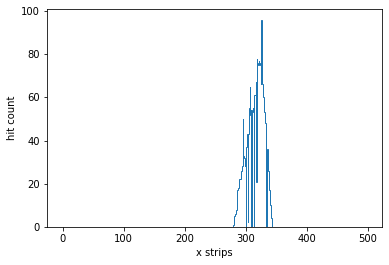

----- Hits on y strips -----


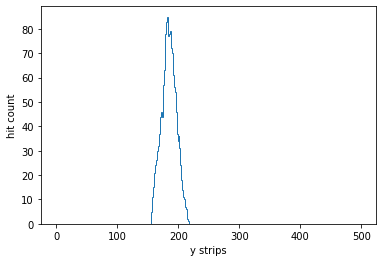

----- Event Time Range-----


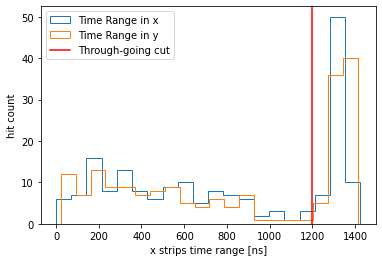

----- ADC distribution-----


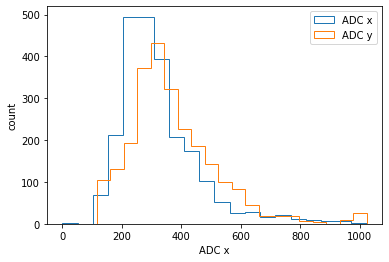

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  59
----- hits in x and y  -----


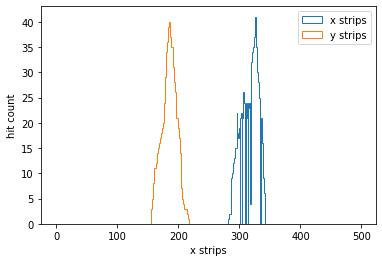

sigma x:  49.37624293185143 +/- 8.060205852786922
sigma y:  53.78063311920274 +/- 11.02167185664383


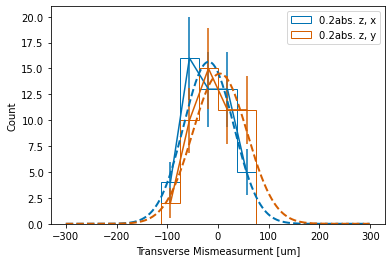

sigma x:  42.72732761172925 +/- 4.843954175457175
sigma y:  39.710213566939714 +/- 3.935292435289187


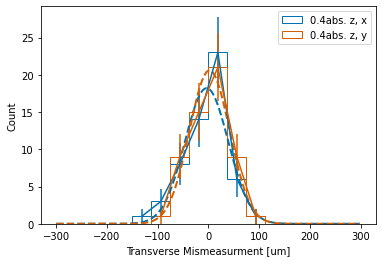

sigma x:  49.121795385230435 +/- 6.142017854220733
sigma y:  35.18724558302154 +/- 3.922738958638204


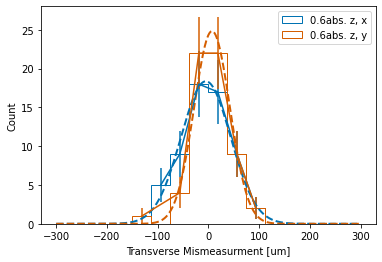

sigma x:  50.05828323525401 +/- 6.584371410933746
sigma y:  44.118271824176524 +/- 4.555557043454473


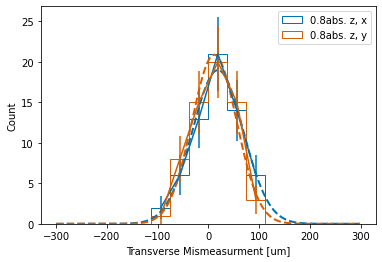

sigma x:  79.0199448544946 +/- 6.412473084723481
sigma y:  78.43322306964008 +/- 8.2090103962374


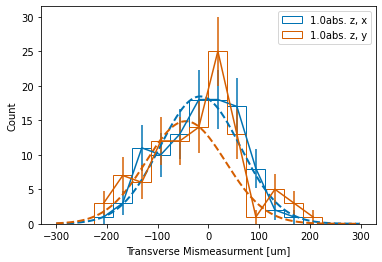

sigma x:  49.592668481457814 +/- 2.10604211140156
sigma y:  42.80229917269581 +/- 1.9004129390036604


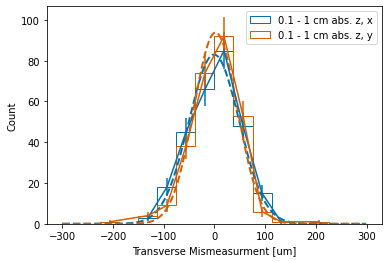

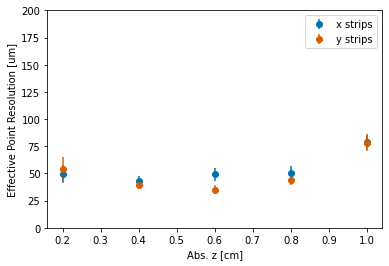

In [56]:
for V in [540]:

    print("-----------", "Vmesh = ", str(V), "-----------")

    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x  / (9.0 *  Mult_factor) ) ) # 9 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / (4.5 * Mult_factor ) ) ) # 4.5 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

    print("selecting tracks fiducial on quadrant a...")
    
    #fiducialize clusters on s ingle vmmm combo in xHyL
    df_cluster = stripROtools.fiducializeVMM(df_cluster, n_vmm_x=5, n_vmm_y=10, min_hits=5, map="UH")


    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC x")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits 
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) ]
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])

    # Loop through tracks after all selection cuts
    for indx in range(len(df_cut)):

        try:

            event = df_cut.iloc[indx]

            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = event, Mult_factor = Mult_factor, gain_x=9, gain_y=4.5, v_drift=8.0)
            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Git mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2)


    plt.figure()
    plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

df_resolution = df_resolution.append({'Name' : "UH_DLC_a", 'x_res' : x_sigmas2, 'x_res_err' : x_sigmas_err2, 'y_res' : y_sigmas2, 'y_res_err' :  y_sigmas_err2, 'abs_z' : abs_z }, ignore_index = True)




# UH NoDLC Micromegas - Quadrant a

In [58]:
# Location of experimental data files

file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_NoDLC/Po210/540Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_NoDLC/Po210/540Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

# multiplicative factor found in Fe55_vmm.ipynb for agreement with PHA analysis
Mult_factor = 1.210

# The edges of the x and y hits
strip_edges = np.arange(-0.5,499.5,1.0)

# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# Solid angle range in theta [degrees]
theta_min = 5
theta_max = 25


----------- Vmesh =  540 -----------
selecting tracks fiducial on quadrant a...
----- Hits on y strips -----


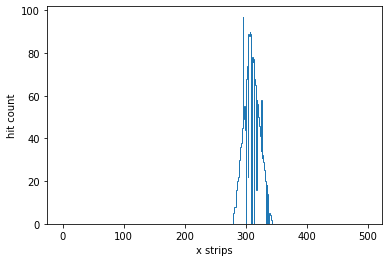

----- Hits on y strips -----


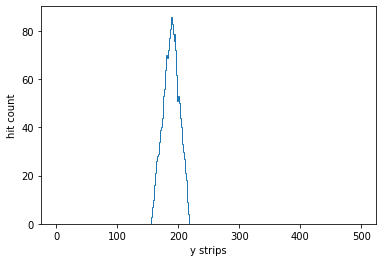

----- Event Time Range-----


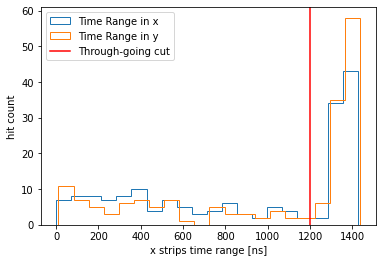

----- ADC distribution-----


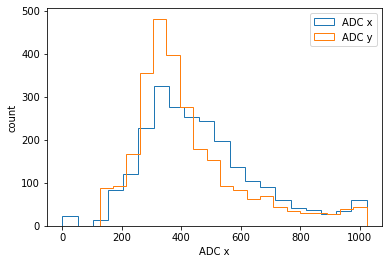

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  68
----- hits in x and y  -----


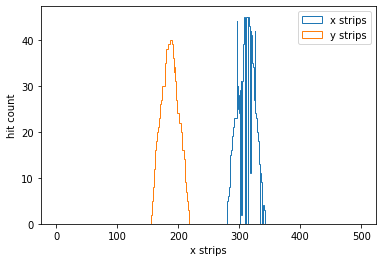

sigma x:  55.29362863299129 +/- 6.650559508891235
sigma y:  33.404396882852375 +/- 3.7852412858994704


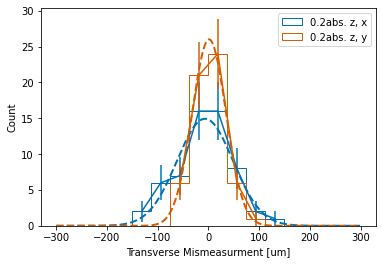

sigma x:  40.92980379868777 +/- 4.203016700035666
sigma y:  47.79383415850631 +/- 10.648521574635893


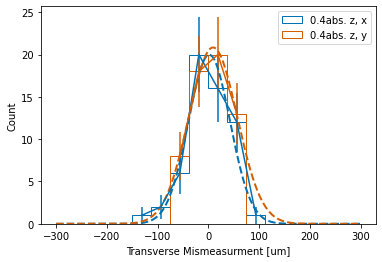

sigma x:  46.45632731733488 +/- 4.829124411153594
sigma y:  46.433174248744585 +/- 7.88803573142084


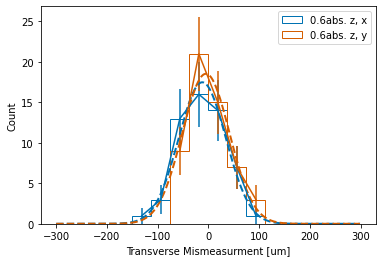

sigma x:  53.54152260647075 +/- 6.454446859971802
sigma y:  42.682718247650634 +/- 4.485745938319375


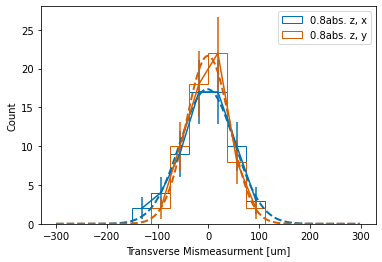

sigma x:  60.3290613506572 +/- 5.448668191152187
sigma y:  63.81905112375668 +/- 6.793998351492189


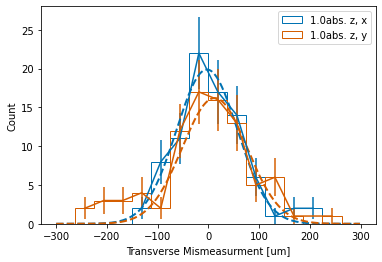

sigma x:  49.00384163689666 +/- 2.3415251646836324
sigma y:  38.076947134906334 +/- 1.6453615726626893


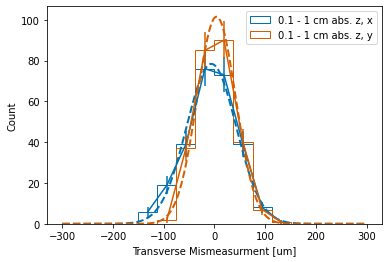

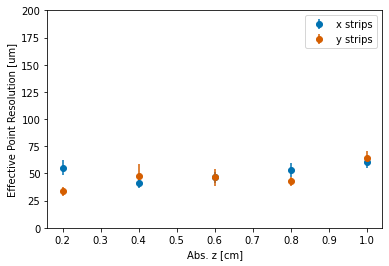

In [59]:
for V in [540]:

    print("-----------", "Vmesh = ", str(V), "-----------")

    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x  / (9.0 *  Mult_factor) ) ) # 9 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / (4.5 * Mult_factor ) ) ) # 4.5 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

    print("selecting tracks fiducial on quadrant a...")
    
    #fiducialize clusters on s ingle vmmm combo in xHyL
    df_cluster = stripROtools.fiducializeVMM(df_cluster, n_vmm_x=5, n_vmm_y=10, min_hits=5, map="UH")


    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC x")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits 
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) ]
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])

    # Loop through tracks after all selection cuts
    for indx in range(len(df_cut)):

        try:

            event = df_cut.iloc[indx]

            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = event, Mult_factor = Mult_factor, gain_x=9, gain_y=4.5, v_drift=8.0)
            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Git mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2)


    plt.figure()
    plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

df_resolution = df_resolution.append({'Name' : "UH_NoDLC_a", 'x_res' : x_sigmas2, 'x_res_err' : x_sigmas_err2, 'y_res' : y_sigmas2, 'y_res_err' :  y_sigmas_err2, 'abs_z' : abs_z }, ignore_index = True)




# UoS

In [60]:
# Location of experimental data files

file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UoS/Po210/870Vmesh_1_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UoS/Po210/870Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

# multiplicative factor found in Fe55_vmm.ipynb for agreement with PHA analysis
Mult_factor = 1.415

# The edges of the x and y hits
strip_edges = np.arange(-0.5,357.5,1.0)

# 3D clustering paramters
mu = T_off.iloc[8]["Mu"]
sigma = T_off.iloc[8]["Sigma"]
n_sigma = 3

# Solid angle range in theta [degrees]
theta_min = 5
theta_max = 25


----------- Vmesh =  870 -----------
----- Hits on y strips -----


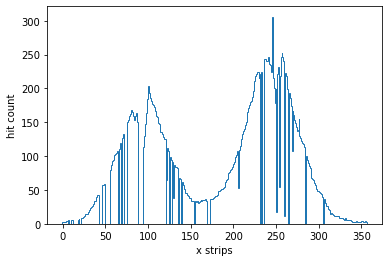

----- Hits on y strips -----


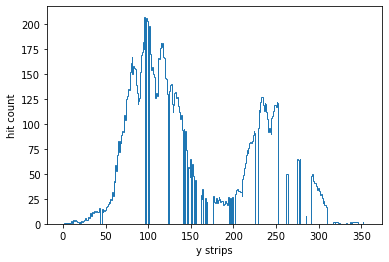

----- Event Time Range-----


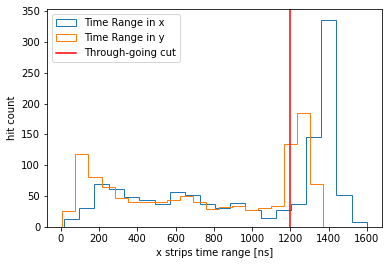

----- ADC distribution-----


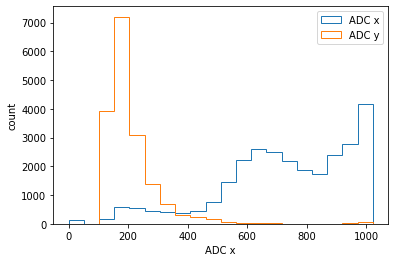

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  259
----- hits in x and y  -----


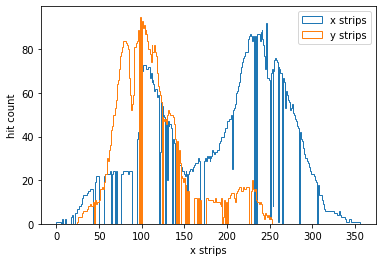

sigma x:  95.7666736435635 +/- 39.46061294585079
sigma y:  34.53300909012184 +/- 6.996992631099758


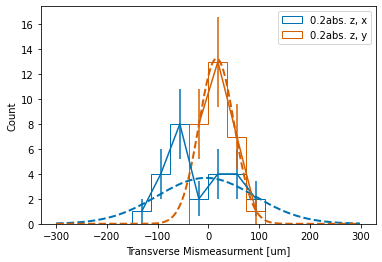

sigma x:  44.32468606574737 +/- 9.665033960326667
sigma y:  44.89354369593178 +/- 9.015357296172645


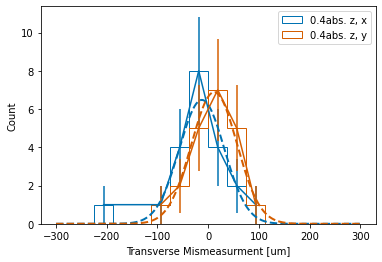

sigma x:  93.09687148231427 +/- 31.033590434411337
sigma y:  41.42528539976449 +/- 12.767897218368407


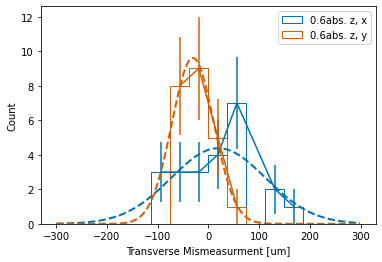

sigma x:  83.92385715457198 +/- 22.861224951054133
sigma y:  35.31514239817486 +/- 8.598722193878345


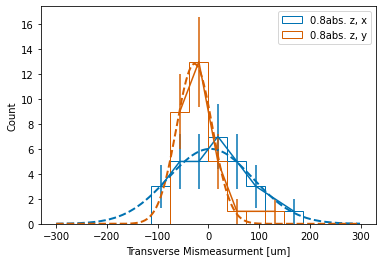

sigma x:  221.5672567832241 +/- 144.66515912501458
sigma y:  78.57812248301883 +/- 20.96696428459131


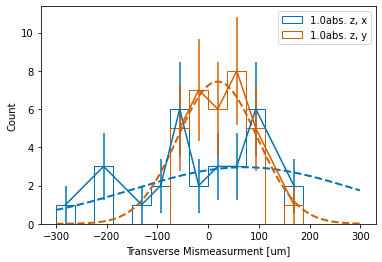

sigma x:  65.66302402022723 +/- 4.888993788584654
sigma y:  40.936163499578264 +/- 2.6241148021925023


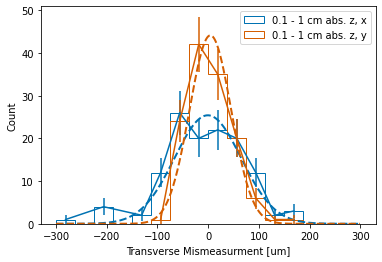

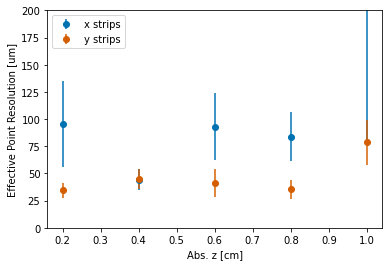

In [61]:
for V in [870]:

    print("-----------", "Vmesh = ", str(V), "-----------")

    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x / (1.0*Mult_factor) ) ) # 1 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / (1.0*Mult_factor) ) ) # 1 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y


    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)




    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC x")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits 
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) ]
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])

    # Loop through tracks after all selection cuts
    for indx in range(len(df_cut)):

        try:

            event = df_cut.iloc[indx]

            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = event, Mult_factor = Mult_factor, gain_x=9, gain_y=4.5, v_drift=8.0)
            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Git mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2)


    plt.figure()
    plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

df_resolution = df_resolution.append({'Name' : "UoS", 'x_res' : x_sigmas2, 'x_res_err' : x_sigmas_err2, 'y_res' : y_sigmas2, 'y_res_err' :  y_sigmas_err2, 'abs_z' : abs_z }, ignore_index = True)




In [64]:
df_resolution.to_pickle("./data/resolution_exp.pk")
df_resolution

,Name,x_res,x_res_err,y_res,y_res_err,abs_z
0,UH_DLC_a,"[49.37624293185143, 42.72732761172925, 49.1217...","[8.060205852786922, 4.843954175457175, 6.14201...","[53.78063311920274, 39.710213566939714, 35.187...","[11.02167185664383, 3.935292435289187, 3.92273...","[0.2, 0.4, 0.6, 0.8, 1.0]"
1,UH_NoDLC_a,"[55.29362863299129, 40.92980379868777, 46.4563...","[6.650559508891235, 4.203016700035666, 4.82912...","[33.404396882852375, 47.79383415850631, 46.433...","[3.7852412858994704, 10.648521574635893, 7.888...","[0.2, 0.4, 0.6, 0.8, 1.0]"
2,UoS,"[95.7666736435635, 44.32468606574737, 93.09687...","[39.46061294585079, 9.665033960326667, 31.0335...","[34.53300909012184, 44.89354369593178, 41.4252...","[6.996992631099758, 9.015357296172645, 12.7678...","[0.2, 0.4, 0.6, 0.8, 1.0]"
